In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy 
from scipy.stats import chi2_contingency, mannwhitneyu
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/raw/healthcare-dataset-stroke-data.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.duplicated().sum()

np.int64(0)

In [4]:
df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,5110.0,NaN,NaN,NaN,36517.829354,21161.721625,67.0,17741.25,36932.0,54682.0,72940.0
gender,5110,3,Female,2994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,5110.0,NaN,NaN,NaN,43.226614,22.612647,0.08,25.0,45.0,61.0,82.0
hypertension,5110.0,NaN,NaN,NaN,0.097456,0.296607,0.0,0.0,0.0,0.0,1.0
heart_disease,5110.0,NaN,NaN,NaN,0.054012,0.226063,0.0,0.0,0.0,0.0,1.0
ever_married,5110,2,Yes,3353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,5110,5,Private,2925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,5110,2,Urban,2596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,5110.0,NaN,NaN,NaN,106.147677,45.28356,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,NaN,NaN,NaN,28.893237,7.854067,10.3,23.5,28.1,33.1,97.6


In [6]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [7]:
df['age'] = df['age'].astype('int64')

In [8]:
df.dtypes

id                     int64
gender                object
age                    int64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [9]:
df.drop(columns=['id'], inplace=True)

In [10]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for cols in numeric_cols:
    print(f'{cols:<30} | Min: {df[cols].min():<10} | Max: {df[cols].max()}')

age                            | Min: 0          | Max: 82
hypertension                   | Min: 0          | Max: 1
heart_disease                  | Min: 0          | Max: 1
avg_glucose_level              | Min: 55.12      | Max: 271.74
bmi                            | Min: 10.3       | Max: 97.6
stroke                         | Min: 0          | Max: 1


In [11]:
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
for col in categorical_cols:
    print(f'{col:<20} | Uniques: {df[col].nunique()} | Examples: {df[col].unique()[:4]}')

gender               | Uniques: 3 | Examples: ['Male' 'Female' 'Other']
ever_married         | Uniques: 2 | Examples: ['Yes' 'No']
work_type            | Uniques: 5 | Examples: ['Private' 'Self-employed' 'Govt_job' 'children']
Residence_type       | Uniques: 2 | Examples: ['Urban' 'Rural']
smoking_status       | Uniques: 4 | Examples: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [12]:
# data quality checks
# missing data
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = ((missing / len(df)) * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing_values' : missing,
    'Missing_pct' : missing_pct
})
missing_summary

,Missing_values,Missing_pct
bmi,201,3.93


In [13]:
# duplicates
duplicates = df[df.duplicated()]
duplicates

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [14]:
# outlier handling
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f'{col:<25} | Outliers: {len(outliers)} | Range: ({lower_bound} - {upper_bound})')

age                       | Outliers: 0 | Range: (-29.0 - 115.0)
hypertension              | Outliers: 498 | Range: (0.0 - 0.0)
heart_disease             | Outliers: 276 | Range: (0.0 - 0.0)
avg_glucose_level         | Outliers: 627 | Range: (21.977500000000006 - 169.35750000000002)
bmi                       | Outliers: 110 | Range: (9.099999999999998 - 47.5)
stroke                    | Outliers: 249 | Range: (0.0 - 0.0)


In [15]:
# shapiro-wilk test
from scipy import stats
def test_normality_shapiro(series):
    '''
    H0 : Data is normally distributed
    H1 : Data is NOT normally distributed
    '''
    series = series.dropna()

    stat, p_value = stats.shapiro(series.sample(min(5000, len(series)), random_state=42))

    return {
        'test' : 'Shapiro-Wilk Normality test',
        'statistic' : stat,
        'p_value' : p_value,
        'normal' : True if p_value >= 0.05 else False
    }

for col in numeric_cols:
    normality = test_normality_shapiro(df[col])
    print(f'{col:<19} | P-value : {round(normality['p_value'],2):<3} | Is Normal : {normality['normal']} ({normality['test']})')

age                 | P-value : 0.0 | Is Normal : False (Shapiro-Wilk Normality test)
hypertension        | P-value : 0.0 | Is Normal : False (Shapiro-Wilk Normality test)
heart_disease       | P-value : 0.0 | Is Normal : False (Shapiro-Wilk Normality test)
avg_glucose_level   | P-value : 0.0 | Is Normal : False (Shapiro-Wilk Normality test)
bmi                 | P-value : 0.0 | Is Normal : False (Shapiro-Wilk Normality test)
stroke              | P-value : 0.0 | Is Normal : False (Shapiro-Wilk Normality test)


In [16]:
def confidence_interval(series, confidence):
    mean = series.dropna().mean()
    std_error = stats.sem(series.dropna())
    margin_error = std_error * stats.t.ppf((1 + confidence) / 2, len(series.dropna() - 1))

    return {
        'Mean' : mean,
        'Lower_bound' : mean - margin_error,
        'Upper_bound' : mean + margin_error,
        'confidence' : confidence
    }

for col in numeric_cols:
    cin = confidence_interval(df[col], 0.95)
    print(f'{col:<25} | Mean: {cin['Mean']:.5f} | Range: ({cin['Lower_bound']:.2f} - {cin['Upper_bound']:.2f})')

age                       | Mean: 43.21526 | Range: (42.59 - 43.84)
hypertension              | Mean: 0.09746 | Range: (0.09 - 0.11)
heart_disease             | Mean: 0.05401 | Range: (0.05 - 0.06)
avg_glucose_level         | Mean: 106.14768 | Range: (104.91 - 107.39)
bmi                       | Mean: 28.89324 | Range: (28.67 - 29.11)
stroke                    | Mean: 0.04873 | Range: (0.04 - 0.05)


In [17]:
def frequency_count(series):
    return {
        'frequency' : series.value_counts(),
        'ratio' : series.value_counts(normalize=True)
    }
for col in categorical_cols:
    fc = frequency_count(df[col])
    fcd = pd.DataFrame({
        'Frequency' : fc['frequency'],
        'Ratio' : fc['ratio']
    })
    print(fcd)

        Frequency     Ratio
gender                     
Female       2994  0.585910
Male         2115  0.413894
Other           1  0.000196
              Frequency     Ratio
ever_married                     
Yes                3353  0.656164
No                 1757  0.343836
               Frequency     Ratio
work_type                         
Private             2925  0.572407
Self-employed        819  0.160274
children             687  0.134442
Govt_job             657  0.128571
Never_worked          22  0.004305
                Frequency     Ratio
Residence_type                     
Urban                2596  0.508023
Rural                2514  0.491977
                 Frequency     Ratio
smoking_status                      
never smoked          1892  0.370254
Unknown               1544  0.302153
formerly smoked        885  0.173190
smokes                 789  0.154403


In [18]:
df[df['stroke'] == 1]['age'].dropna().mean()
df[df['stroke'] ==0]['age'].dropna().mean()

np.float64(41.95967907837893)

In [19]:
def compare_two_groups(
        df, numeric_col, grouping_col, grouping_val1, grouping_val2, alpha
):
    group1 = df[df[grouping_col] == grouping_val1][numeric_col].dropna()
    group2 = df[df[grouping_col] == grouping_val2][numeric_col].dropna()

    if len(group1) < 3 or len(group2) < 3:
        print(f'Insufficient data. Analyzes not possible')

    sample_size = min(5000, len(group1), len(group2))
    _, p1 = stats.shapiro(group1.sample(min(sample_size, len(group1)), random_state=42))
    _, p2 = stats.shapiro(group2.sample(min(sample_size, len(group2)), random_state=42))

    if p1 < alpha or p2 < alpha:
        stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
        test_type = 'mannwhitneyu'
    else:
        stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
        test_type = "Welch's t-test"

    # effect size
    import sys
    try:
        pooled_std = np.sqrt((group1.std()**2 + group2.std()**2) / len(df))
        cohens_d = abs(group1.mean() - group2.mean()) /  pooled_std if pooled_std else 0
    except ZeroDivisionError as e:
        print(f'Pooled std is zero. Cannot calculate effect size')
        sys.exit(1)
    if cohens_d < 0.2:
        effect_interpretation = 'negligible'
    elif cohens_d < 0.5:
        effect_interpretation = 'small'
    elif cohens_d < 0.8:
        effect_interpretation = 'medium'
    else:
        effect_interpretation = 'large'

    return {
        'test_type': test_type,
        'group1_mean': round(float(group1.mean()), 4),
        'group2_mean': round(float(group2.mean()), 4),
        'group1_std': round(float(group1.std()), 4),
        'group2_std': round(float(group2.std()), 4),
        'group1_n': len(group1),
        'group2_n': len(group2),
        'statistic': round(float(stat), 4),
        'p_value': round(float(p_value), 6),
        'significant': p_value < alpha,
        'cohens_d': round(float(cohens_d), 4),
        'effect_interpretation': effect_interpretation
    }

from joblib import Parallel, delayed
results = Parallel(n_jobs=-1, backend='threading')(
    delayed(compare_two_groups)(
        df, col, 'stroke', 0, 1, 0.05
    )
    for col in numeric_cols[:-1]
)

ttest_results = {
        col: result for col, result in zip(numeric_cols, results) 
        if result is not None
    }


for col, result in ttest_results.items():

    print(
        f'{col}\n\nGroup1 mean : {result['group1_mean']}\nGroup2 mean : {result['group2_mean']}\n'
        f'P-value : {result['p_value']}\nSignificance : {result['significant']}\nCohens_d : {result['cohens_d']}'
        f'\nEffect Interpretation : {result['effect_interpretation']}\n({result['test_type']})\n'
        )

age

Group1 mean : 41.9597
Group2 mean : 67.7269
P-value : 0.0
Significance : True
Cohens_d : 71.6944
Effect Interpretation : large
(mannwhitneyu)

hypertension

Group1 mean : 0.0889
Group2 mean : 0.2651
P-value : 0.0
Significance : True
Cohens_d : 23.9487
Effect Interpretation : large
(mannwhitneyu)

heart_disease

Group1 mean : 0.0471
Group2 mean : 0.1888
P-value : 0.0
Significance : True
Cohens_d : 22.7183
Effect Interpretation : large
(mannwhitneyu)

avg_glucose_level

Group1 mean : 104.7955
Group2 mean : 132.5447
P-value : 0.0
Significance : True
Cohens_d : 26.1442
Effect Interpretation : large
(mannwhitneyu)

bmi

Group1 mean : 28.8231
Group2 mean : 30.4713
P-value : 0.000103
Significance : True
Cohens_d : 11.6318
Effect Interpretation : large
(mannwhitneyu)



In [20]:
def chi_square_test(df, cat_col, target_col, alpha):
    contingency_table = pd.crosstab(df[cat_col], df[target_col])

    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    if (expected < 5).any():
        print(f'{cat_col} : Expected frequencies less than 5, results may be unreliable')

    #Craimer's V effect size
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v =  np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0 

    if cramers_v < 0.1: 
        effect_interpretation = 'negligible'
    elif cramers_v < 0.3:
        effect_interpretation = 'small'
    elif cramers_v < 0.5:
        effect_interpretation = 'medium'
    else:
        effect_interpretation = 'high'

    return {
        'chi2': round(float(chi2), 4),
        'p_value': round(float(p_value), 6),
        'dof': int(dof),
        'cramers_v': round(float(cramers_v), 4),
        'effect_interpretation': effect_interpretation,
        'significant': True if p_value < alpha else False,
        'contingency_table': contingency_table.to_dict()
    }

chi_square_results = {}
for col in categorical_cols:
    result = chi_square_test(df, col, 'stroke', 0.05)
    chi_square_results[col] = result


    print(
        f'{col}\nChi-square = {result['chi2']}\nP-value = {result['p_value']}\n'
        f'Signifance = {result['significant']}\nCramers_v = {result['cramers_v']}\n'
        f'Effect interpretation = {result['effect_interpretation']}\n'
    )


gender : Expected frequencies less than 5, results may be unreliable
gender
Chi-square = 0.4726
P-value = 0.789549
Signifance = False
Cramers_v = 0.0096
Effect interpretation = negligible

ever_married
Chi-square = 58.9239
P-value = 0.0
Signifance = True
Cramers_v = 0.1074
Effect interpretation = small

work_type : Expected frequencies less than 5, results may be unreliable
work_type
Chi-square = 49.1635
P-value = 0.0
Signifance = True
Cramers_v = 0.0981
Effect interpretation = negligible

Residence_type
Chi-square = 1.0816
P-value = 0.298332
Signifance = False
Cramers_v = 0.0145
Effect interpretation = negligible

smoking_status
Chi-square = 29.1473
P-value = 2e-06
Signifance = True
Cramers_v = 0.0755
Effect interpretation = negligible



In [21]:
corr = df.corr(numeric_only=True, method='spearman')
corr

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.280648,0.269628,0.145161,0.375648,0.249538
hypertension,0.280648,1.000000,0.108306,0.114041,0.167493,0.127904
heart_disease,0.269628,0.108306,1.000000,0.106360,0.066144,0.134914
avg_glucose_level,0.145161,0.114041,0.106360,1.000000,0.114370,0.082541
bmi,0.375648,0.167493,0.066144,0.114370,1.000000,0.055445
stroke,0.249538,0.127904,0.134914,0.082541,0.055445,1.000000


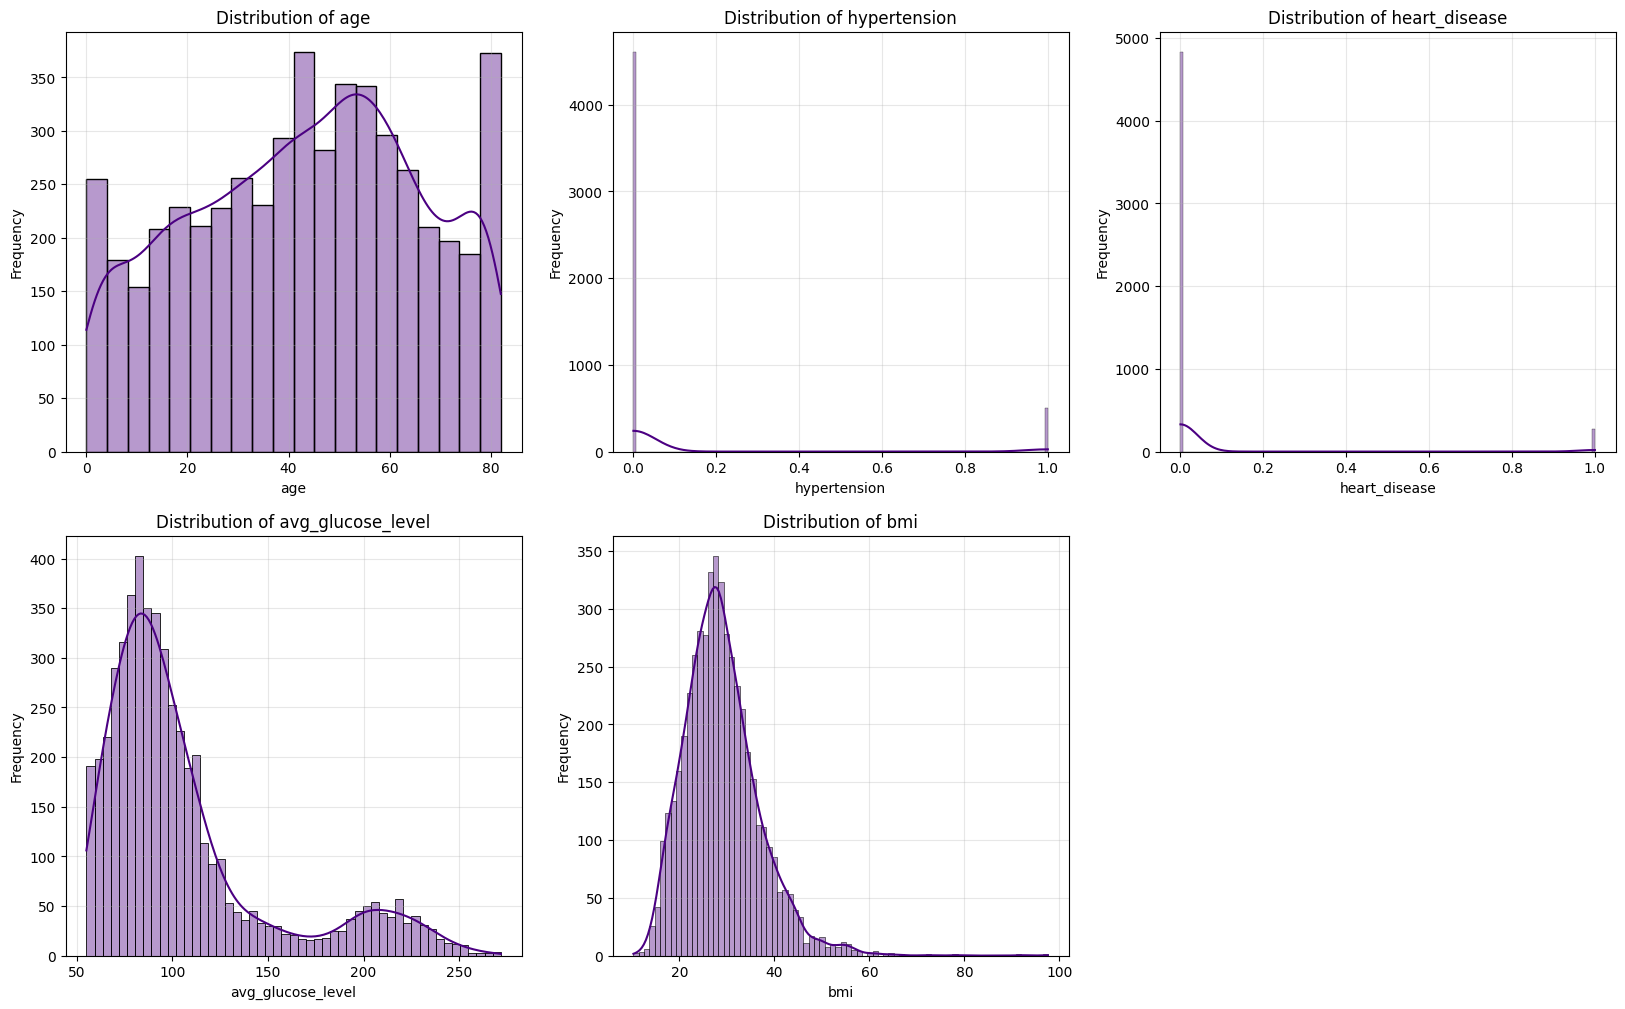

In [22]:
# distributions
plt.figure(figsize=(20,12))
for i, col in enumerate(numeric_cols[:-1]):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=col, kde=True, alpha=0.4, color='indigo')
    plt.ylabel(f'Frequency')
    plt.title(f'Distribution of {col}')
    plt.grid(True, alpha=0.3)
plt.show()

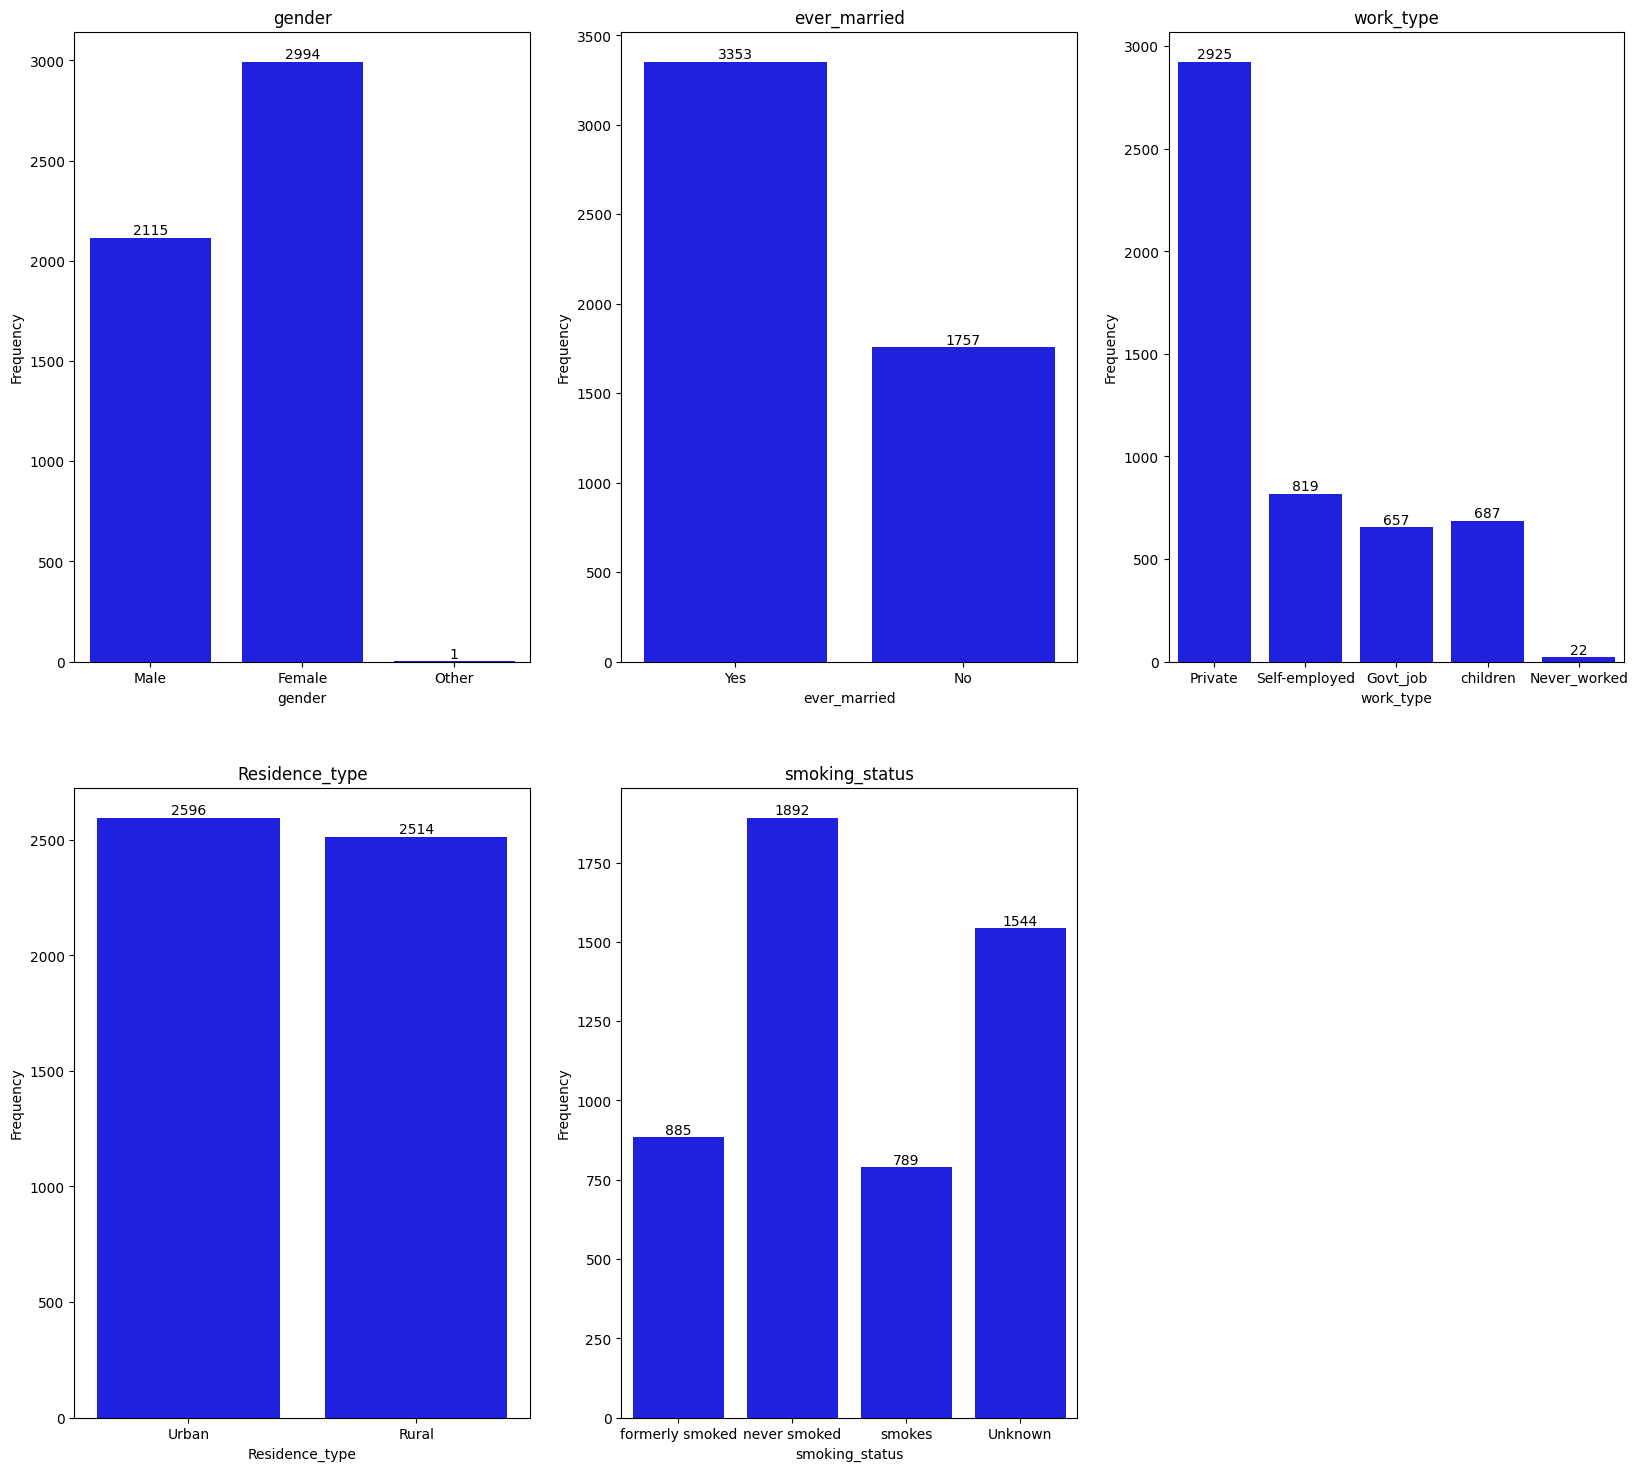

In [23]:
plt.figure(figsize=(20,18))
for i,col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1)
    ax = sns.countplot(data=df, x=col,color='blue')
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')

    ax.set_title(f'{col}')
    ax.set_ylabel(f'Frequency')
plt.show()

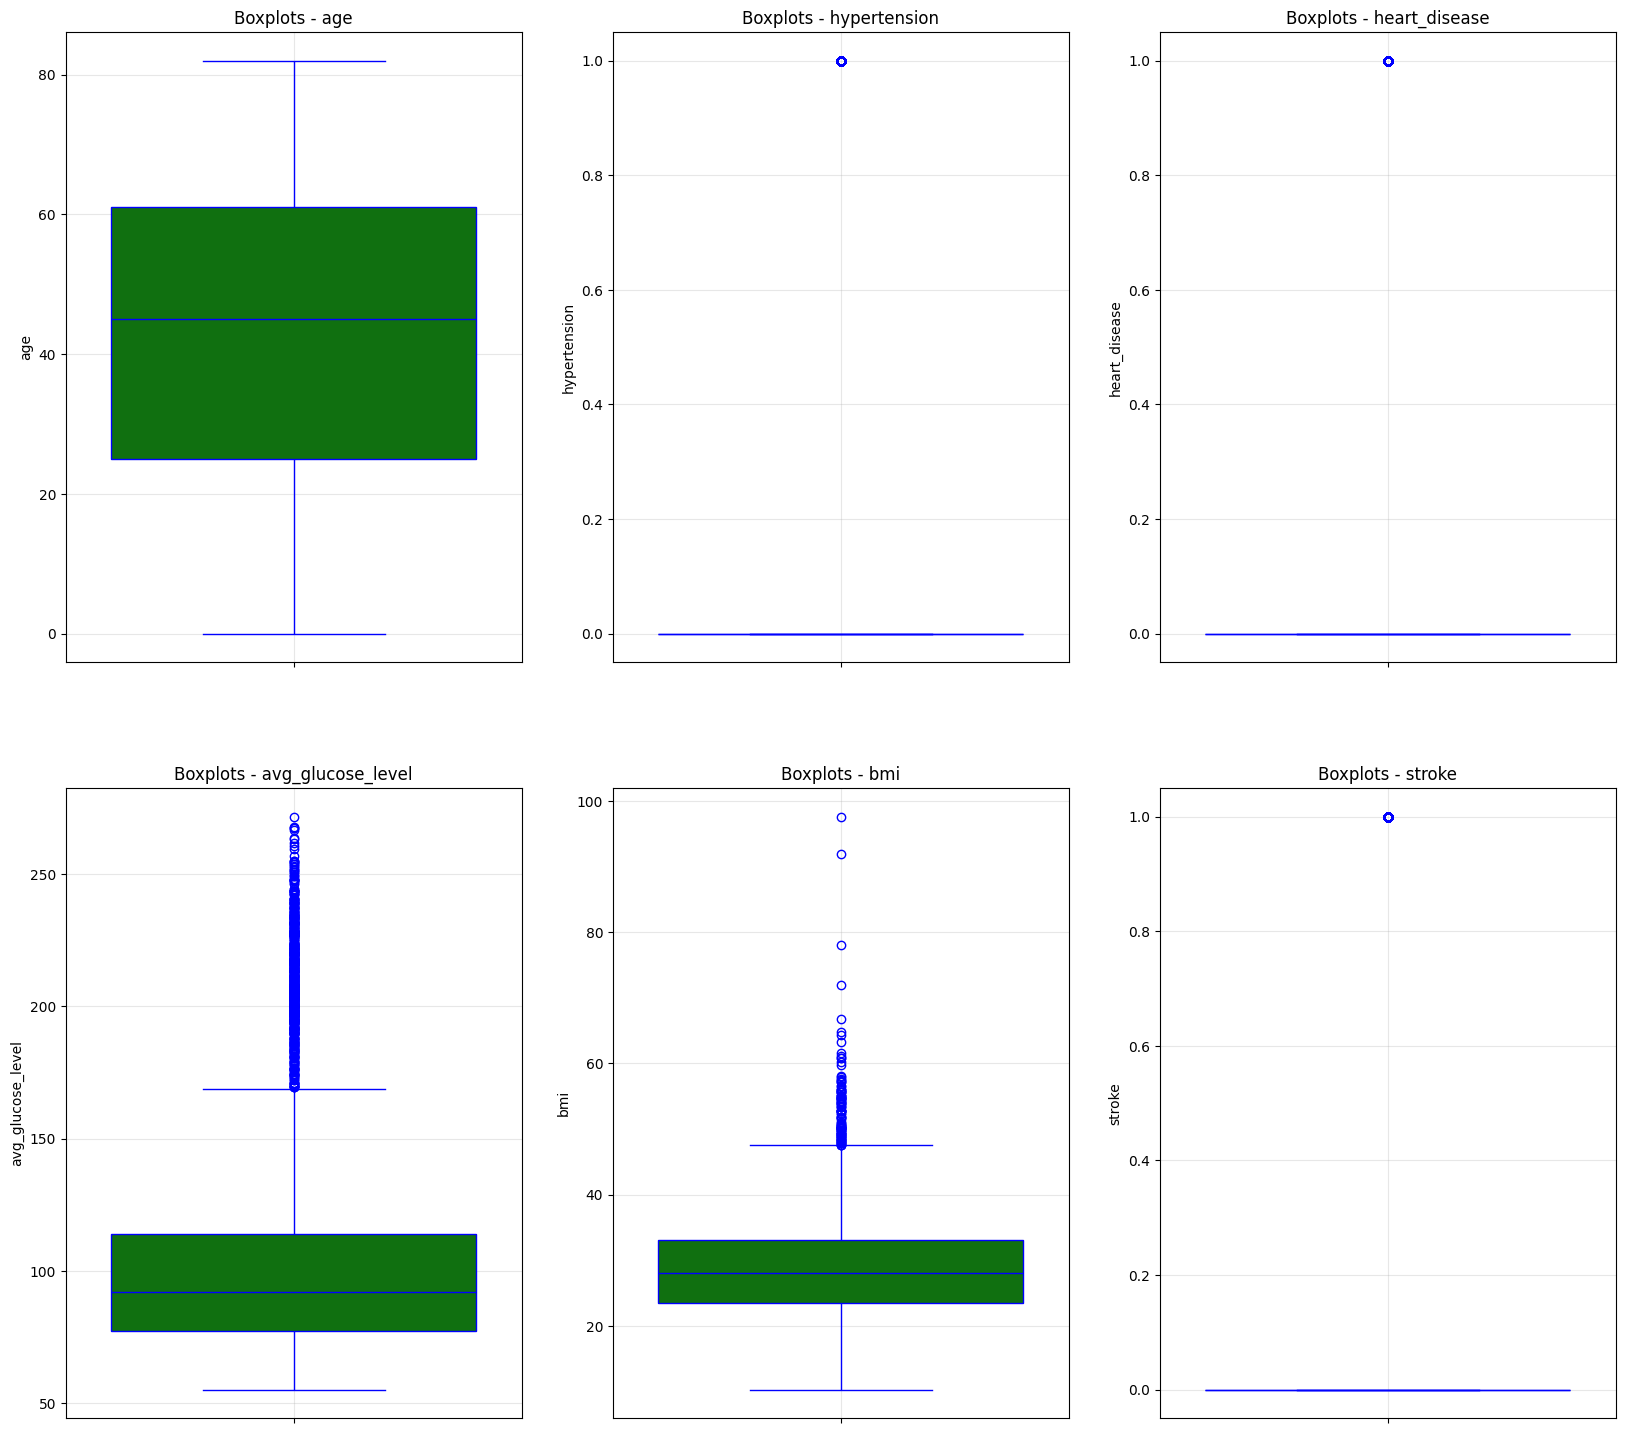

In [24]:
# boxplots
plt.figure(figsize=(20,18))
for i,col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, y=col, color='green', linecolor='blue')
    plt.title(f'Boxplots - {col}')
    plt.grid(True, alpha=0.3)
plt.show()

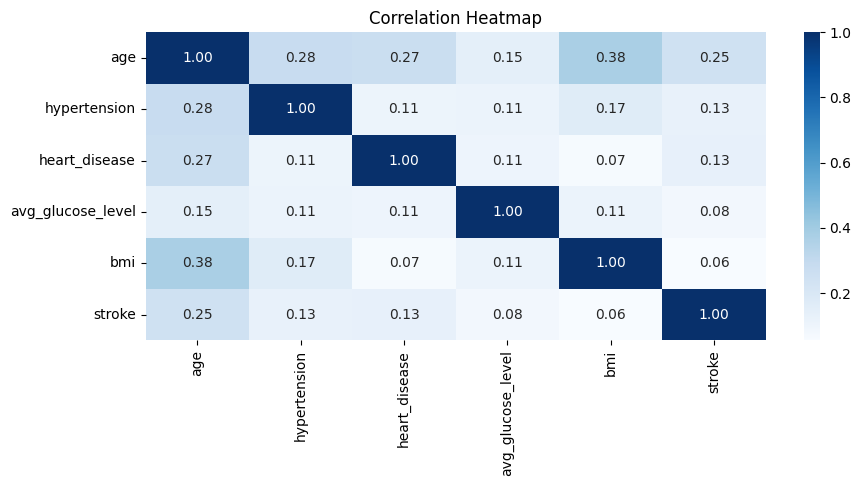

In [25]:
# heatmap
corr = df.corr(numeric_only=True, method='spearman')
plt.figure(figsize=(10,4))
sns.heatmap(data=corr,fmt='.2f', annot=True, cmap='Blues')
plt.title(f'Correlation Heatmap')
plt.show()

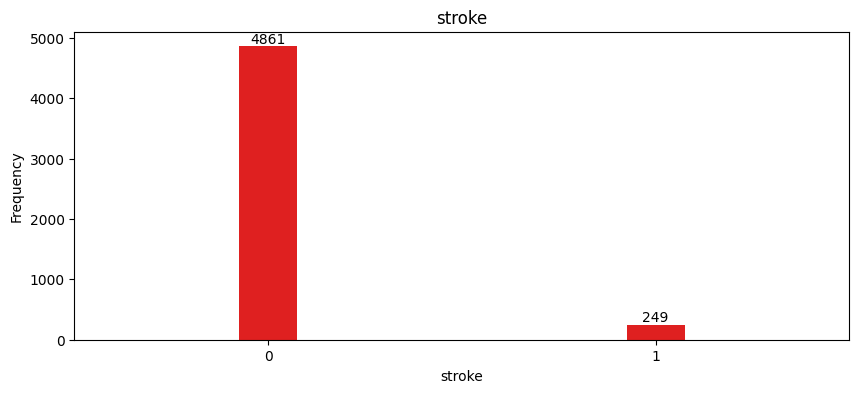

In [31]:
# target analysis
plt.figure(figsize=(10,4))
ax = sns.countplot(data=df, x='stroke',color='red', gap=0.5, width=0.3)
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

ax.set_title(f'{col}')
ax.set_ylabel(f'Frequency')
plt.show()